In [1]:
%load_ext autoreload
%autoreload 2

# Load Dependencies

In [2]:
import matplotlib.pyplot as plt

import torch

import pyro
import numpy as np
import pyro.distributions as dist
# from pyro.poutine import trace, replay, block
# from pyro.infer.autoguide.guides import AutoDelta, AutoNormal
# from pyro.infer import SVI, Trace_ELBO, Predictive

import sys
sys.path.append("../../src/")

from pyciemss.ODE.askem_primitives import sample, infer_parameters, intervene, optimization

#
from pyciemss.utils import get_tspan

import warnings
warnings.filterwarnings('ignore')

/Users/zuck016/.pyenv/versions/jz-scenario2-eval/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Plotting Utilities

In [14]:
def setup_ax(ax=None):

    if not ax:
        fig = plt.figure(facecolor='w', figsize=(9, 9))
        ax = fig.add_subplot(111, axisbelow=True)

    ax.set_xlabel('Time /days')
    ax.set_ylabel('Infected (1000s)')
    return ax

def plot_predictive(prediction, tspan, tmin=None, ax=None, alpha=0.2, color="black", **kwargs):
    vars = ["I_total_obs"]
    #infection_total = sum([prediction[x].squeeze().detach().numpy()/1000. for x in ['I_obs', 'D_obs', 'A_obs', 'R_obs', 'T_obs']])

    I_low = torch.quantile(prediction["I_total_obs"], 0.05, dim=0).detach().numpy()
    I_up = torch.quantile(prediction["I_total_obs"], 0.95, dim=0).detach().numpy()

    if tmin:
        indeces = tspan >= tmin
    else:
        indeces = torch.ones_like(tspan).bool()

    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
    
    ax.fill_between(tspan[indeces], I_low[indeces], I_up[indeces], alpha=alpha, color=color, **kwargs)

    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)

    return ax

def plot_trajectory(data, tspan, ax=None, color='black', alpha=0.5, lw=0, marker='.', label=None, observation='I_total_obs'):
    # Plot the data on three separate curves for S(t), I(t) and R(t)

    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
    #infection_total = sum([data[x].squeeze().detach().numpy()/1000. for x in ['I_obs', 'D_obs', 'A_obs', 'R_obs', 'T_obs']])
    ax.plot(tspan, data[observation].squeeze().detach().numpy(), color, alpha=alpha, lw=lw, marker=marker, label=label)
    
    return ax

def plot_intervention_line(t, ax=None):
    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

    ylim = ax.get_ylim()

    ax.vlines(t, min(ylim), max(ylim), color="grey", ls='-')

    return ax

def LogNormalPrior(mean, variance):
    mu = torch.log(mean**2/torch.sqrt((mean**2 + variance)))
    scale = torch.sqrt(torch.log(1 + variance/mean**2))
    return dist.LogNormal(mu, scale)

# Setup Parameters

In [4]:
full_tspan = get_tspan(1, 100, 100)

num_samples = 100

# Total population, N.
N = 1
# Initial number of infected and recovered individuals, I0 and R0.
I0, D0, A0, R0, T0, H0, E0 = 200/60e6, 20/60e6, 1/60e6, 2/60e6, 0, 0, 0

# Everyone else, S0, is susceptible to infection initially.

S0 = N - I0 - D0 - A0 - R0 - T0 - H0 - E0


#I_obs = torch.tensor([81.47, 84.3, 86.44, 89.66, 93.32, 94.1, 96.31])

initial_state = tuple(torch.as_tensor(s) for s in  (S0, I0, D0, A0, R0, T0, H0, E0))
final_observed_state = tuple(torch.as_tensor(s) for s in  (S0, I0, D0, A0, R0, T0, H0, E0))

# Probabilistic Forecasting - Passing unit test 1
There are two ‘unit tests’ we want to pass, to ensure that we understood and can reproduce the published model:

## 1.a Unit Test \#1:

Set the initial values and parameters, as described in the Supplementary Methods section of the publication (pg. 9 of the pdf): 

1. Initial Values: 
* $I = 200/60e6$,
* $D = 20/60e6$, 
* $A = 1/60e6$, 
* $R = 2/60e6$, 
* $T = 0$, 
* $H = 0$, 
* $E = 0$; 
* $S = 1 – I – D – A – R – T – H – E$. 

Let total population = 60e6.
Parameters: $$\alpha = 0.570, \beta = \delta  = 0.011, \gamma = 0.456, \epsilon = 0.171, \theta = 0.371, \zeta = \eta = 0.125, \mu = 0.017, \nu = 0.027, \tau = 0.01, \lambda = \rho = 0.034$$ and $$\kappa = \xi = \sigma = 0.017$$.

In [9]:
from pyciemss.ODE.models import SIDARTHE

pyro.set_rng_seed(0)

ode_model = SIDARTHE(N=1,
                 alpha_prior=dist.Delta(torch.tensor (0.570)) ,
                 beta_prior=dist.Delta(torch.tensor (0.011)) ,
                 gamma_prior=dist.Delta(torch.tensor (0.456)) ,
                 delta_prior=dist.Delta(torch.tensor (0.011)) ,
                 epsilon_prior=dist.Delta(torch.tensor (0.171)) ,
                 lamb_prior =dist.Delta(torch.tensor (0.034)) ,
                 zeta_prior=dist.Delta(torch.tensor (0.125)) ,
                 eta_prior=dist.Delta(torch.tensor (0.125)) ,
                 kappa_prior=dist.Delta(torch.tensor (0.017)) ,
                 theta_prior=dist.Delta(torch.tensor (0.371)) ,
                 rho_prior=dist.Delta(torch.tensor (0.034)) ,
                 xi_prior=dist.Delta(torch.tensor (0.017)) ,
                 sigma_prior=dist.Delta(torch.tensor (0.017)) ,
                 mu_prior=dist.Delta(torch.tensor (0.017)) ,
                 nu_prior=dist.Delta(torch.tensor (0.027)) ,
                 tau_prior=dist.Delta(torch.tensor (0.01)) )

In [24]:
from pyciemss.ODE.models import MIRA_SIDARTHE

plotting_ode_model = MIRA_SIDARTHE.from_mira('../../test/models/evaluation_examples/scenario_2/ta_2/scenario2_sidarthe.json')

In [22]:
#prior_prediction = sample(plotting_ode_model, num_samples, initial_state, full_tspan)
single_prediction = sample(plotting_ode_model, 1, initial_state, full_tspan)
single_prediction.keys()

dict_keys(["flux_trans_(('Susceptible', ('identity', 'ido:0000514')), ('Infected', ('identity', 'ido:0000511'), ('disease_status', 'ncit:C3833'), ('property', 'ncit:C113725')), ('Diagnosed', ('identity', 'ido:0000511'), ('property', 'ncit:C15220')), 'ControlledConversion') 1.0", "flux_trans_(('Susceptible', ('identity', 'ido:0000514')), ('Infected', ('identity', 'ido:0000511'), ('disease_status', 'ncit:C3833'), ('property', 'ncit:C113725')), ('Ailing', ('identity', 'ido:0000511'), ('disease_status', 'ncit:C25269'), ('property', 'ncit:C113725')), 'ControlledConversion') 1.0", "flux_trans_(('Susceptible', ('identity', 'ido:0000514')), ('Infected', ('identity', 'ido:0000511'), ('disease_status', 'ncit:C3833'), ('property', 'ncit:C113725')), ('Recognized', ('identity', 'ido:0000511'), ('disease_status', 'ncit:C25269'), ('property', 'ncit:C25587')), 'ControlledConversion') 1.0", "flux_trans_(('Susceptible', ('identity', 'ido:0000514')), ('Infected', ('identity', 'ido:0000511'), ('disease_st

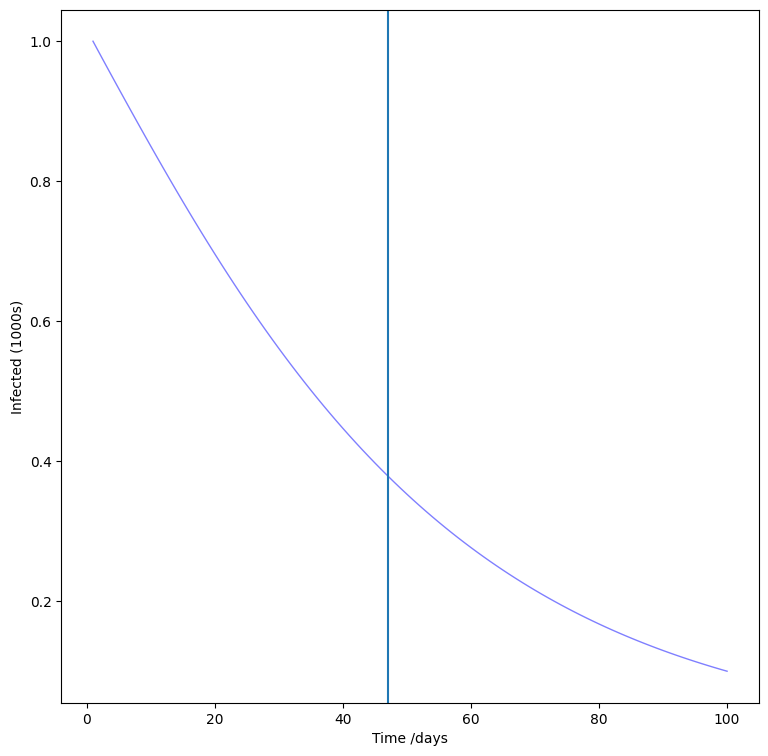

In [23]:
ax = plot_trajectory(single_prediction, full_tspan, ax=setup_ax(), color="blue", marker='', lw=1., label="Before Seeing Data - Single Forecast",
                    observation='obs_total_infections')
#ax = plot_predictive(prior_prediction, full_tspan, ax=ax, label="Before Seeing Data - Probabilistic Forecast", color="red")
ax.axvline(47)

## 1.b Unit Test \#2: 

Now update the parameters to reflect various interventions that Italy implemented during the first wave, as described in detail on pg. 9.  Simulate for 100 days, reproduce the trajectories in Fig. 2B, and determine the day and level of peak total infections (sum over all the infected states I, D, A, R, T). Expected output: Trajectories in Fig. 2B, peak occurs around day 50, with ~0.2% of the total population infected.

### Day 4 social distancing
After day 4, as a consequence of basic social-distancing measures due to the public being aware of the epidemic outbreak and due to recommendations (such  as washing hands often, not touching one’s face, avoiding handshakes and keeping  distance) and early measures (such as closing schools) by the Italian government,  we set $\alpha= 0.422, \beta = \delta = 0.0057$  and $\gamma = 0.285$, so the new basic reproduction number becomes $R_0 = 1.66$.

### Day 12 screening limited to symptomatic individuals
Also, after day 12, we set $\epsilon  = 0.143$ as a consequence of the policy limiting screening to symptomatic individuals only; thus, totally asymptomatic individuals  are almost no longer detected, while individuals with very mild symptoms are still  detected (hence $\epsilon$ is not set exactly to zero). Due to this, $R_0 = 1.80$. 

Simulate for $100$ days, and determine the day and level of peak total infections (sum over all the infected states $I, D, A, R, T$). Expected output: The peak should occur around day $47$, when $\sim 60\%$ of the population is infected.

### Day 22 incomplete lockdown
After day 22, the lockdown, at first incomplete, yields $\alpha  = 0.360,  \beta = \delta = 0.005$  and $\gamma = 0.200$;  also, $\zeta = \eta = 0.034, \mu = 0.008, \nu = 0.015, \lambda = 0.08$  and  $\rho= \kappa = \xi = \sigma = 0.017$. Hence, the new basic reproduction number becomes $R_0 = 1.60$. 

### Day 28 fully operational lockdown
After day 28, the lockdown is fully operational and gets stricter (working is no longer a good reason for going out: gradually, non-indispensable activities are  stopped): we get $\alpha  = 0.210$ and $\gamma = 
0.110$,  hence $R_0 = 0.99$. 

### Day 38 wider testing campaign launched
After day 38, a wider testing campaign is launched: this yields $\epsilon  = 0.200$,  and also $\rho  = \kappa = \xi = 0.020$,  while $\sigma = 0.010$  and $\zeta = \eta = 0.025$.  Therefore, $R_0 = 0.85$.

In [8]:
from pyciemss.ODE.models import SIDARTHE

pyro.set_rng_seed(0)

var_prior = 0.05**2

ode_model = SIDARTHE(N=1,
                 alpha_prior=LogNormalPrior(torch.tensor(0.570), torch.tensor(var_prior)) ,
                 beta_prior=LogNormalPrior(torch.tensor(0.011), torch.tensor(var_prior)) ,
                 gamma_prior=LogNormalPrior(torch.tensor(0.456), torch.tensor(var_prior)) ,
                 delta_prior=LogNormalPrior(torch.tensor(0.011), torch.tensor(var_prior)) ,
                 epsilon_prior=LogNormalPrior(torch.tensor(0.171), torch.tensor(var_prior)) ,
                 lamb_prior =LogNormalPrior(torch.tensor(0.034), torch.tensor(var_prior)) ,
                 zeta_prior=LogNormalPrior(torch.tensor(0.125), torch.tensor(var_prior)) ,
                 eta_prior=LogNormalPrior(torch.tensor(0.125), torch.tensor(var_prior)) ,
                 kappa_prior=LogNormalPrior(torch.tensor(0.017), torch.tensor(var_prior)) ,
                 theta_prior=LogNormalPrior(torch.tensor(0.371), torch.tensor(var_prior)) ,
                 rho_prior=LogNormalPrior(torch.tensor(0.034), torch.tensor(var_prior)) ,
                 xi_prior=LogNormalPrior(torch.tensor(0.017), torch.tensor(var_prior)) ,
                 sigma_prior=LogNormalPrior(torch.tensor(0.017), torch.tensor(var_prior)) ,
                 mu_prior=LogNormalPrior(torch.tensor(0.017), torch.tensor(var_prior)) ,
                 nu_prior=LogNormalPrior(torch.tensor(0.027), torch.tensor(var_prior)) ,
                 tau_prior=LogNormalPrior(torch.tensor(0.01), torch.tensor(var_prior)) )

In [9]:
prior_prediction = sample(ode_model, num_samples, initial_state, full_tspan)
# single_prediction = sample(ode_model, 1, initial_state, full_tspan)
# ax = plot_trajectory(single_prediction, full_tspan, ax=setup_ax(), color="blue", marker='', lw=1., label="Before Seeing Data - Single Forecast")

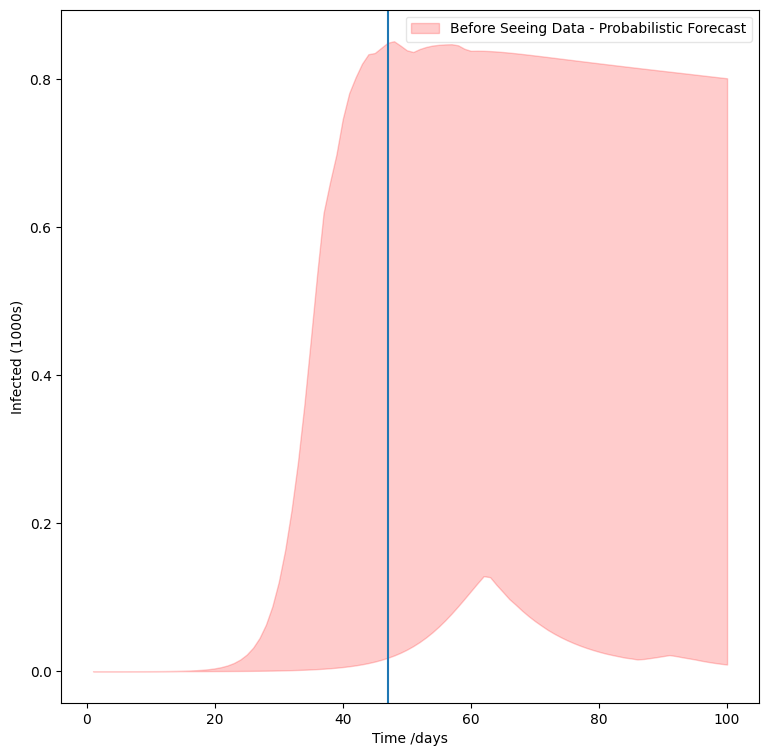

In [10]:
ax1 = plot_predictive(prior_prediction, full_tspan, ax=setup_ax(), label="Before Seeing Data - Probabilistic Forecast", color="red")
ax1.axvline(47)

## 1.c Sensitivity analysis

## 1.d Policies that prevent infections from exceeding 1/3 of the population

Now return to the situation in b.i (constant parameters that don’t change over time). Let’s say we want to increase testing, diagnostics, and contact tracing efforts (implemented by increasing the detection parameters  and ). Assume that $\theta \ge 2\epsilon$ , because a symptomatic person is more likely to be tested. What minimum constant values do these parameters need to be over the course of a 100-day simulation, to ensure that the total infected population (sum over all the infected states I, D, A, R, T) never rises above 1/3 of the total population?




### Problem Formulation
* **Quantity of interest**:  Total infections out of $N=60,000,000$ population
$$I_{total}(t; \mathbf{u}, \mathbf{Z}) = I(t) + D(t) + A(t) + R(t) + T(t)$$

A conservative estimate for the quantity of interest is
$$M(u, Z) = \max_{1\leq t \leq 100} I_{total}(t; \mathbf{u}, \mathbf{Z})/N$$




* **Control**: $\mathbf{u}\in \mathcal{U} \subseteq \mathbb{R}^{n_u}$
    * Detection parameter for Infected ($\epsilon$) assuming that $\theta=2\epsilon$
    * Two detection parameters $\theta, \epsilon$, constraining $\theta \ge 2\epsilon$.
    


* **Risk-based optimization under uncertainty problem formulation**
    * Objective Function - Minimize the magnitude of the parameter interventions.
    * Constraint - Risk of normalized total infections exceeding the prescribed threshold of $1/3$, $\mathcal{R}( M(\mathbf{u},\mathbf{Z}))$, is below the acceptable risk threshold, $\mathcal{R}_\text{threshold}$.

\begin{equation} 
\begin{split} 
\mathbf{u}^*= \underset{\mathbf{u}\in\mathcal{U}}{\arg\min}\ & \lVert \mathbf{u} \rVert_1 \\ \text{s.t.}\ & \mathcal{R}( M(\mathbf{u}, \theta)) \le \mathcal{R}_\text{threshold} 
\end{split} 
\end{equation}

#### Formulation 1: Optimize $\epsilon$ only, assuming $\theta = 2\epsilon$
\begin{equation} 
\begin{split} 
\epsilon^*= \underset{\epsilon\in\mathcal{U}}{\arg\min}\ & \epsilon \\ \text{s.t.}\ & \mathbb{P}( M(\epsilon, \mathbf{Z}) \ge 1/3) \le 0.05
\end{split} 
\end{equation}

#### Formulation 2: Optimize $\epsilon$ and $\theta$ constraining $\theta \ge 2\epsilon$
\begin{equation} 
\begin{split} 
\epsilon^\ast, \theta^\ast= \underset{\{\epsilon,\theta\}\in\mathcal{U}}{\arg\min}\ & \theta + \epsilon \\ \text{s.t.}\ & \mathbb{P}( M(\epsilon,\theta, \mathbf{Z}) \ge 1/3) \le 0.05, \\
& \theta \ge 2\epsilon
\end{split} 
\end{equation}

Apart from probability of exceedance, we will explore quantiles and superquantiles as risk measures.

# Probabilistic Forecasting - Exploring Possible Interventions


In [16]:

from causal_pyro.query.do_messenger import do
from pyciemss.ODE.interventions import constant_intervention_builder, time_dependent_intervention_builder, state_dependent_intervention_builder, parameter_intervention_builder
new_tspan = full_tspan


## Q: "What would happen if we set the diagnosis rate parameter for infected, $\epsilon$?"


In [47]:
pyro.set_rng_seed(0)

# # Apply intervention to model
# intervened_model = do(self.model, self.intervention_fun(x))
# samples = Predictive(intervened_model, guide=None, num_samples=num_samples)(initial_state, new_tspan)
        
# rate_parameter_intervention = parameter_intervention_builder("epsilon", torch.tensor([0.3]))
# rate_parameter_intervention = parameter_intervention_builder("epsilon", torch.tensor([0.3]))
# intervened_parameter_model = do(plotting_ode_model, rate_parameter_intervention)
# plotting_intervened_parameter_model = intervene(ode_model, rate_parameter_intervention)
plotting_intervened_parameter_model = do(ode_model, {"epsilon": torch.tensor([0.5]), "theta": torch.tensor([1.])})
# intervened_parameter_prediction = Predictive(intervened_parameter_model, guide=guide, num_samples=num_samples)(final_observed_state, new_tspan)
intervened_parameter_prediction = sample(plotting_intervened_parameter_model, num_samples, initial_state, new_tspan)
# posterior_prediction = Predictive(plotting_intervened_parameter_model, guide=None, num_samples=num_samples)(initial_state, new_tspan)

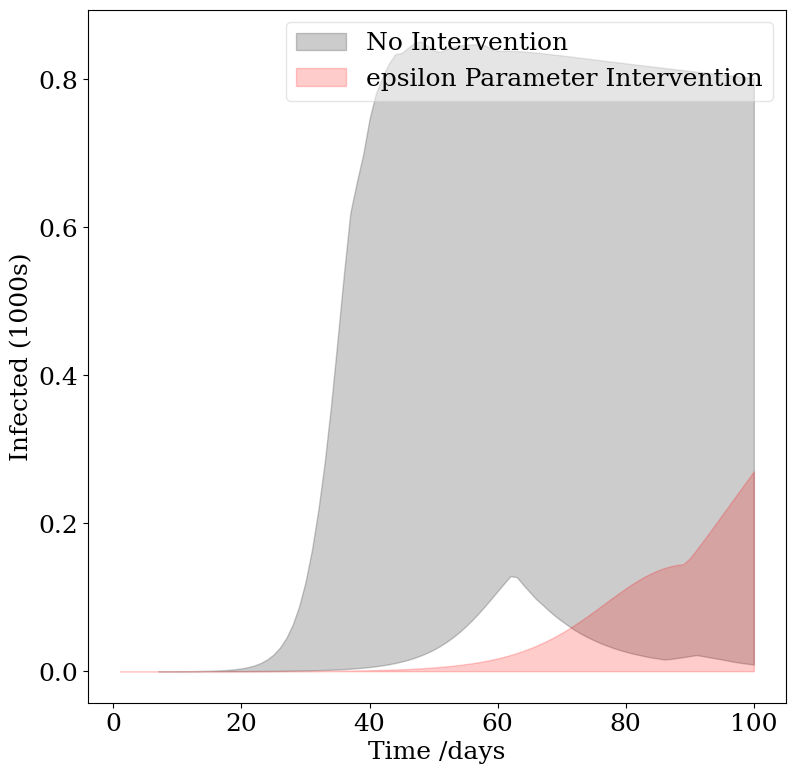

In [48]:
ax = setup_ax()
# ax = plot_trajectory(data, observed_tspan, ax=ax)
ax = plot_predictive(prior_prediction, new_tspan, tmin=7, ax=ax, label="No Intervention")
ax = plot_predictive(intervened_parameter_prediction, new_tspan, ax=ax, color='red', label="epsilon Parameter Intervention")

In [49]:
import os
import time
import pickle

import numpy as np
from scipy import stats
from matplotlib import ticker

# from pyciemss.ODE.models import SVIIvR
from pyciemss.ODE.interventions import constant_intervention_builder, parameter_intervention_builder

from pyciemss.risk.risk_measures import alpha_quantile, alpha_superquantile
from pyciemss.risk.ouu import computeRisk
from pyciemss.risk.qoi import max_total_infections_SIDARTHE

# Plotting helpers
def sideaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return

def sideaxishist(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    # For y-axis
    ax.yaxis.set_major_locator(ticker.NullLocator())
    ax.tick_params(axis='x', labelsize=12)  # change fontsize for x-axis tick labels
    # ax.xaxis.major.formatter._useMathText = True
    return


co = ['#377eb8', '#ff7f00', '#984ea3', '#ffd92f', '#a65628']
rlabel = ['Q_alpha-based OUU', 'barQ_alpha-based OUU']

## Exploring the difference between Quantiles and Super-Quantiles

In [50]:
torch.manual_seed(1)

POLICY = np.array([0.4])
N_SAMPLES = 100

RISK = computeRisk(model=ode_model,
#                  intervention_fun=lambda x: parameter_intervention_builder("epsilon", torch.from_numpy(x)),
                 intervention_fun=lambda x: {"epsilon": torch.from_numpy(x), "theta": torch.from_numpy(2*x)},
                 qoi=lambda y: max_total_infections_SIDARTHE(y, contexts=["I_total_obs"]),
                 risk_measure=alpha_superquantile,
                 num_samples=N_SAMPLES,
                 model_state=final_observed_state,
                 tspan=new_tspan,
                 guide=None)

start_time = time.time()
sq_dataCube = RISK.propagate_uncertainty(POLICY)
end_time = time.time()
forward_time = end_time - start_time
time_per_eval = forward_time / N_SAMPLES
print(f"Forward UQ took {forward_time:.2f} seconds total ({forward_time/N_SAMPLES:.2e} seconds per model evaluation).")
sq_qoi = RISK.qoi(sq_dataCube)
sq_sv = RISK.risk_measure(sq_qoi)

RISK.risk_measure = alpha_quantile
q_sv = RISK(POLICY)

Forward UQ took 16.29 seconds total (1.63e-01 seconds per model evaluation).


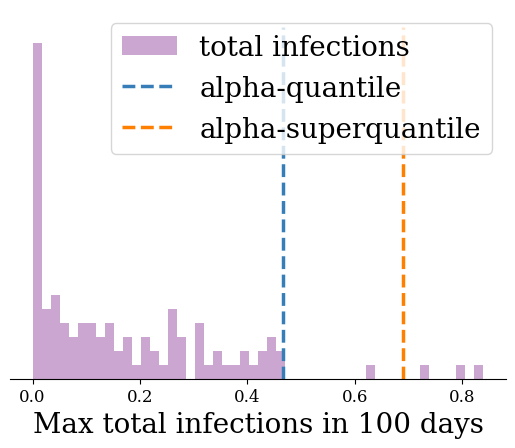

In [52]:
bins_hist = 50
fig1 = plt.figure()
plt.rc('text', usetex=False)
plt.rc('font', family='serif', size=18.)
cax = plt.gca()
sideaxishist(cax)
cax.hist(sq_qoi, color=co[2], bins=bins_hist, histtype='stepfilled', alpha=0.5, label='total infections')
miny = min(cax.get_ylim())
maxy = max(cax.get_ylim())
cax.vlines(q_sv, miny, maxy, linestyle='--', linewidth=2.5, label='alpha-quantile', color=co[0])
cax.vlines(sq_sv, miny, maxy, linestyle='--', linewidth=2.5, label='alpha-superquantile', color=co[1])
cax.set_xlabel('Max total infections in 100 days', size=20)
cax.legend(loc='upper right', prop={'size': 20})
plt.show()

## Risk-based optimization under uncertainty with intervention on detection rate parameter $\epsilon$
**NOTE:** This is a demonstration of the interface, optimization is not run to convergence nor are enough samples generated to accurately estimate the risk, so take the results with a grain of salt.

In [54]:
from pyciemss.risk.ouu import RandomDisplacementBounds, computeRisk, solveOUU
from pyciemss.risk.qoi import nday_rolling_average
from pyciemss.risk.risk_measures import alpha_superquantile, alpha_quantile
import scipy

# Define problem specifics.
RISK_BOUND = 1./3.
X_MIN = 0.
X_MAX = 2
N_SAMPLES = int(1e1)
MAXITER = 2
TOL = 1e-5

RISK_ALPHA = 0.95

# Control action / intervention.
INIT_ITERATE = 0.5
# INTERVENTION = lambda x: parameter_intervention_builder("nu", torch.tensor(x))
INTERVENTION = lambda x: {"epsilon": torch.from_numpy(x), "theta": torch.from_numpy(2*x)}

# Objective function.
OBJFUN = lambda x: x  # minimize the scalar value itself.

# Define the risk measure.
VAX_RISK = computeRisk(
                        model=ode_model,
                        intervention_fun=INTERVENTION,
                        qoi=lambda y: max_total_infections_SIDARTHE(y, contexts=["I_total_obs"]),
                        model_state=final_observed_state,
                        tspan=new_tspan,
                        risk_measure=lambda z: alpha_superquantile(z, alpha=RISK_ALPHA),
                        num_samples=N_SAMPLES,
                        guide=None,
                        )

# Define problem constraints.
CONSTRAINTS = (
                # risk constraint
                {'type': 'ineq', 'fun': lambda x: RISK_BOUND - VAX_RISK(x)},

                # bounds on control
                # NOTE: perhaps use scipy.optimize.LinearConstraint in the future
                {'type': 'ineq', 'fun': lambda x: x - X_MIN},
                {'type': 'ineq', 'fun': lambda x: X_MAX - x}
               )

In [55]:
print("Performing risk-based optimization under uncertainty ...")
print(f"Estimated wait time {time_per_eval*N_SAMPLES*MAXITER:.0f} seconds.")
sq_result = solveOUU(
                     x0=INIT_ITERATE,
                     objfun=OBJFUN,
                     constraints=CONSTRAINTS,
                     optimizer_algorithm="COBYLA",
                     tol=TOL,
                     options={
                         "disp": False,
                         "maxiter": MAXITER
                             },
                    ).solve()
print(f"Optimizer finished. Optimal Vaccination rate is:\t{sq_result.x[0]:.4}")
est_risk = VAX_RISK(sq_result.x[0])
print(f"Estimated risk was:\t{est_risk:.2f}")

Performing risk-based optimization under uncertainty ...
Estimated wait time 3 seconds.


TypeError: expected np.ndarray (got numpy.float64)

## Assess the effect of the control policy.

In [ ]:
intervened_prediction = VAX_RISK.propagate_uncertainty(POLICY)
qois = VAX_RISK.qoi(intervened_prediction)

In [ ]:

ax = setup_ax()
ax = plot_trajectory(data, observed_tspan, ax=ax)
ax = plot_predictive(posterior_prediction, new_tspan, tmin=7, ax=ax, label="No Intervention")
ax = plot_predictive(intervened_prediction, new_tspan, ax=ax, color='red', label="Vaccination Rate Parameter Intervention")
ax = plot_intervention_line(7., ax=ax)


In [ ]:
bins_hist = 50
fig1 = plt.figure()
# plt.rc('text')
plt.rc('font', family='serif', size=18.)
cax = plt.gca()
sideaxishist(cax)
cax.hist(qois, color=co[2], bins=bins_hist, histtype='stepfilled', alpha=0.5, label='total infections (intervened)', density=True)
cax.hist(VAX_RISK.qoi(posterior_prediction)), color=co[4], bins=bins_hist, histtype='stepfilled', alpha=0.5, label='do nothing', density=True)
miny = min(cax.get_ylim())
maxy = max(cax.get_ylim())
cax.vlines(est_risk, miny, maxy, linestyle='--', linewidth=2.5, label='alpha-superquantile', color=co[1])
cax.set_xlabel('7-day average infections at 90 days', size=20)
cax.legend(loc='upper right', prop={'size': 20})
plt.show()